In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from torcheval.metrics.functional import multiclass_f1_score

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Load Fashion MNIST
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# Split dataset 
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

In [4]:
# Create dataloaders
batch_size = 1000
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


In [5]:
# plot an image
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

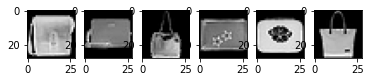

In [6]:
# View 6 bags
view_fashionmnist(8, 6)

In [18]:
from torch.nn.modules.flatten import Flatten
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        first_conv2d_stack  =  64
        second_conv2d_stack = 128
        third_conv2d_stack  = 256
        fourth_conv2d_stack = 512
        fifth_conv2d_stack  = 512
        linear_stack = fifth_conv2d_stack*2*2

        self.pipeline = nn.Sequential(
            # First stack of convolutional layers
            nn.Conv2d(in_channels = 1, out_channels = first_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(first_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = first_conv2d_stack, out_channels = first_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(first_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = first_conv2d_stack, out_channels = first_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(first_conv2d_stack),
            nn.ReLU(),

            # Second stack of convolutional layers
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 28x28 -> 14x14
            nn.Conv2d(in_channels = first_conv2d_stack, out_channels = second_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(second_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = second_conv2d_stack, out_channels = second_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(second_conv2d_stack),
            nn.ReLU(),

            # Third stack of convolutional layers            
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 14x14 -> 7x7
            nn.Conv2d(in_channels = second_conv2d_stack, out_channels = third_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(third_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = third_conv2d_stack, out_channels = third_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(third_conv2d_stack),
            nn.ReLU(),

            # Fourth stack of convolutional layers
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 7x7 -> 3x3
            nn.Conv2d(in_channels = third_conv2d_stack, out_channels = fourth_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = fourth_conv2d_stack, out_channels = fourth_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_conv2d_stack),
            nn.ReLU(),

            # Fifth stack of convolutional layers
            nn.MaxPool2d(kernel_size = 2, stride = 1), # 3x3 -> 2x2
            nn.Conv2d(in_channels = fourth_conv2d_stack, out_channels = fifth_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(fifth_conv2d_stack),
            nn.ReLU(),
            nn.Conv2d(in_channels = fifth_conv2d_stack, out_channels = fifth_conv2d_stack, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(fifth_conv2d_stack),
            nn.ReLU(),

            # Multilayer perceptron
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(linear_stack),
            nn.Linear(linear_stack, 10),
        )
        
    def forward(self, x):
        return self.pipeline(x)


In [21]:
learning_rate = 0.001
num_epochs = 50
dropout = 0.50
weight_decay = 0.001

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    best_f1 = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
        training_curves[phase+'_f1'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            f1_scores = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
                f1_scores += torch.sum(multiclass_f1_score(predictions, labels.data, num_classes=10, average='macro'))
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_scores / (dataset_sizes[phase] / batch_size)
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)       
            training_curves[phase+'_f1'].append(epoch_f1)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_f1 = epoch_f1

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch} with F1-score: {best_f1}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [22]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.6458 Acc: 0.7615 F1: 0.7543
val   Loss: 0.4734 Acc: 0.8271 F1: 0.8111
test  Loss: 0.4844 Acc: 0.8283 F1: 0.8117

Epoch 2/50
----------
train Loss: 0.3126 Acc: 0.8859 F1: 0.8849
val   Loss: 0.3509 Acc: 0.8745 F1: 0.8719
test  Loss: 0.3694 Acc: 0.8693 F1: 0.8663

Epoch 3/50
----------
train Loss: 0.2494 Acc: 0.9110 F1: 0.9105
val   Loss: 0.3249 Acc: 0.8851 F1: 0.8834
test  Loss: 0.3524 Acc: 0.8807 F1: 0.8784

Epoch 4/50
----------
train Loss: 0.2088 Acc: 0.9249 F1: 0.9246
val   Loss: 0.3516 Acc: 0.8772 F1: 0.8711
test  Loss: 0.3688 Acc: 0.8733 F1: 0.8662

Epoch 5/50
----------
train Loss: 0.1819 Acc: 0.9342 F1: 0.9339
val   Loss: 0.2827 Acc: 0.9031 F1: 0.9031
test  Loss: 0.3030 Acc: 0.8946 F1: 0.8947

Epoch 6/50
----------
train Loss: 0.1650 Acc: 0.9413 F1: 0.9411
val   Loss: 0.3151 Acc: 0.8935 F1: 0.8931
test  Loss: 0.3364 Acc: 0.8852 F1: 0.8849

Epoch 7/50
----------
train Loss: 0.1515 Acc: 0.9453 F1: 0.9450
val   Loss: 0.2672 Acc: 0.9103 F1: 0.9098

In [23]:
torch.save(model.state_dict(), 'fashionMNIST_model')

In [24]:
model = CNNClassifier()
model.load_state_dict(torch.load('fashionMNIST_model'))
model = model.to(device)
model.eval()



CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [12]:
# Plotting results
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc', 'f1']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc' or metric == 'f1':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


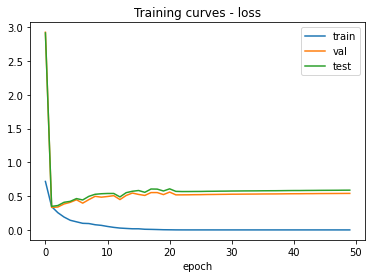

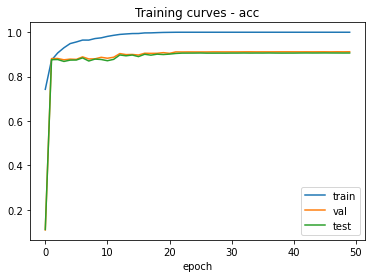

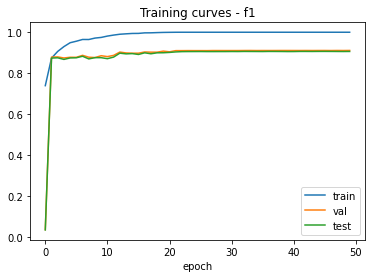

In [13]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

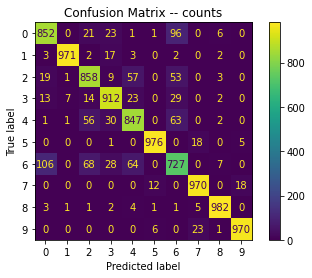

In [14]:
res = plot_cm(model, device, dataloaders, phase='test')

* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot